# Assignment: More Xarray with El Niño-Southern Oscillation (ENSO) Data

Here will will calculate the NINO 3.4 index of El Nino variabillity and use it to analyze datasets.

First read [this page from NOAA](https://www.ncei.noaa.gov/access/monitoring/enso/sst). It tells you the following:

- The Niño 3.4 region is defined as the region between +/- 5 deg. lat, 170 W - 120 W lon.
- Warm or cold phases of the Oceanic Niño Index are defined by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above the threshold of +0.5°C (warm), or below the threshold of -0.5°C (cold). This is known as the Oceanic Niño Index (ONI).

(Note that "anomaly" means that the seasonal cycle, also called the "climatology" has been removed.)

Source: https://earth-env-data-science.github.io/assignments/more_xarray.html

Start by importing Numpy, Matplotlib, and Xarray. Set the default figure size to (12, 6).

In [29]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

### 1. Reproduce the SST curve from the figure below

Use the `sst.mnmean.nc` file that we worked with in class, located at <http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc>.

You don't have to match the stylistic details, or use different colors above and below zero, just the "3mth running mean" curve.

![enso](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/eln-f-pg.gif)

Load the data as an Xarray dataset. Drop the `time_bnds` variable as we did in class and trim the data to 1950 onward for this assignment.

In [30]:
sst = xr.open_dataset("http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc").drop_vars("time_bnds")
sst = sst.sel(time=slice("1950", "2018"))
sst

<xarray.Dataset> Size: 53MB
Dimensions:  (lat: 89, lon: 180, time: 828)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2018-12-01
Data variables:
    sst      (time, lat, lon) float32 53MB ...
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2025-01-03
    DODS_EXTRA.Unlimited_Dimension:  time

Now calculate the climatology and the SST anomaly.
Find a location you are interested in and plot how it changes with time.

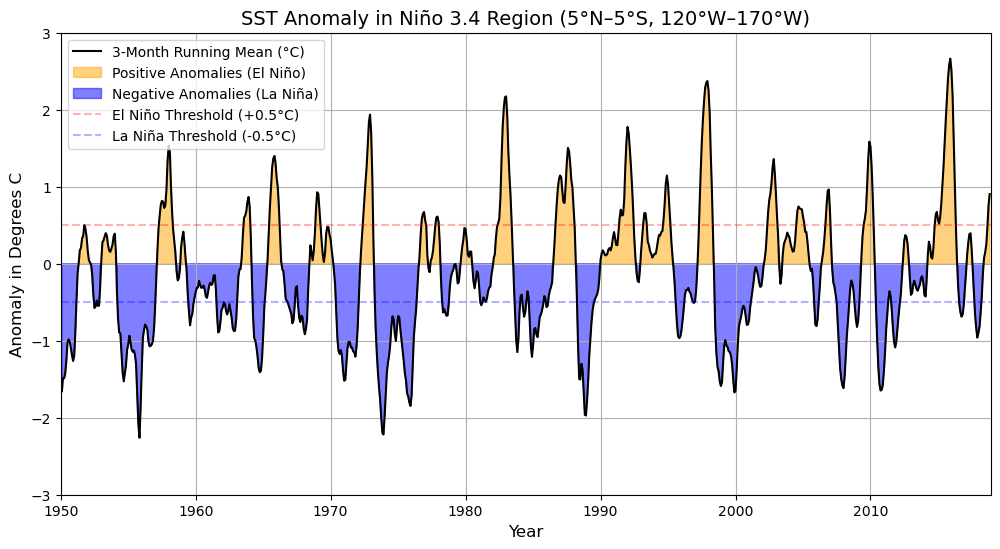

In [59]:
# Extract the SST variable as a DataArray
sst_da = sst['sst']

# Subset the baseline period for climatology (1981–2010)
baseline = sst_da.sel(time=slice("1981-01-01", "2020-12-31"))

# Calculate climatology (monthly means over the baseline period)
climatology = baseline.groupby('time.month').mean(dim='time')

# Calculate SST anomaly (subtract climatology from full dataset)
sst_anomaly = sst_da.groupby('time.month') - climatology

# Subset the Niño 3.4 region using where
nino34_region = sst_anomaly.where(
    (sst_anomaly.lat >= -5) & (sst_anomaly.lat <= 5) &
    (sst_anomaly.lon >= 190) & (sst_anomaly.lon <= 240),
    drop=True
)

# Calculate the spatial mean for the Niño 3.4 region
nino34_mean = nino34_region.mean(dim=['lat', 'lon'])

# Calculate the 3-month running mean (Oceanic Niño Index)
nino34_3m_mean = nino34_mean.rolling(time=3, center=True).mean()

# Plot the SST anomaly 3-month running mean
plt.figure(figsize=(12, 6))

# Main plot: Black line for 3-month running mean
plt.plot(nino34_3m_mean['time'], nino34_3m_mean, label="3-Month Running Mean (°C)", color="black")

# Shaded regions
plt.fill_between(
    nino34_3m_mean['time'],
    0,
    nino34_3m_mean,
    where=nino34_3m_mean > 0,
    color="orange",
    alpha=0.5,
    label="Positive Anomalies (El Niño)"
)
plt.fill_between(
    nino34_3m_mean['time'],
    0,
    nino34_3m_mean,
    where=nino34_3m_mean < 0,
    color="blue",
    alpha=0.5,
    label="Negative Anomalies (La Niña)"
)

# Threshold lines
plt.axhline(0.5, color="red", linestyle="--", alpha=0.3, label="El Niño Threshold (+0.5°C)")
plt.axhline(-0.5, color="blue", linestyle="--", alpha=0.3, label="La Niña Threshold (-0.5°C)")

# Title and labels
plt.title("SST Anomaly in Niño 3.4 Region (5°N–5°S, 120°W–170°W)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Anomaly in Degrees C", fontsize=12)

# Grid, legend, and limits
plt.grid()
plt.legend()
plt.ylim(-3, 3)  # Match the y-axis range in the example graph
plt.xlim(nino34_3m_mean['time'].values.min(), nino34_3m_mean['time'].values.max())

# Show the plot
plt.show()

Now reproduce the plot above. Keep the rolling 3-month average of the SST anomaly as a DataArray for the next question.

### 2. Calculate boolean timeseries representing the positive / negative ENSO phases

Refer to the definitions of warm/cold phases above.

In [48]:
# Calculate boolean time series for ENSO phases
el_nino_phase = (nino34_3m_mean >= 0.5)  # El Niño: SST anomaly >= +0.5°C
la_nina_phase = (nino34_3m_mean <= -0.5)  # La Niña: SST anomaly <= -0.5°C
neutral_phase = (nino34_3m_mean > -0.5) & (nino34_3m_mean < 0.5)  # Neutral: -0.5°C < SST anomaly < +0.5°C

# Optional: Convert to integers (1 = True, 0 = False)
el_nino_phase = el_nino_phase.astype(int)
la_nina_phase = la_nina_phase.astype(int)
neutral_phase = neutral_phase.astype(int)

# Print the results for verification
print("El Niño Phase:")
print(el_nino_phase)
print("La Niña Phase:")
print(la_nina_phase)
print("Neutral Phase:")
print(neutral_phase)

El Niño Phase:
<xarray.DataArray 'sst' (time: 828)> Size: 7kB
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0

Plot them somehow.

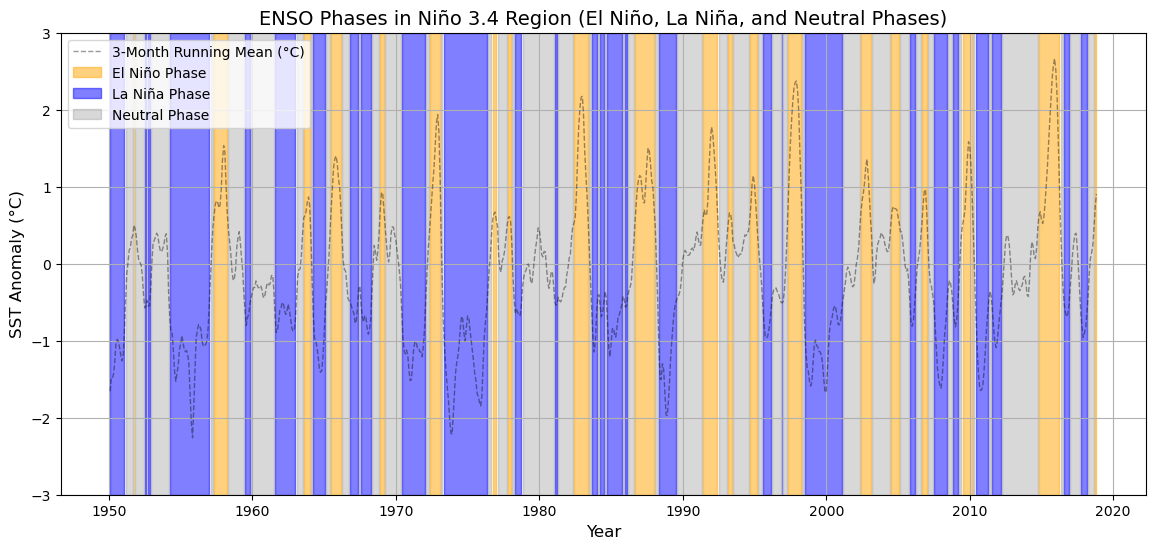

In [54]:
plt.figure(figsize=(14, 6))

# 3-Month Running Mean Line
plt.plot(nino34_3m_mean['time'], nino34_3m_mean, label="3-Month Running Mean (°C)", color="black", linewidth=1, linestyle="--", alpha=0.4)

# Shaded areas for each phase
plt.fill_between(
    nino34_3m_mean['time'], -3, 3,
    where=el_nino_phase, color="orange", alpha=0.5, label="El Niño Phase"
)
plt.fill_between(
    nino34_3m_mean['time'], -3, 3,
    where=la_nina_phase, color="blue", alpha=0.5, label="La Niña Phase"
)
plt.fill_between(
    nino34_3m_mean['time'], -3, 3,
    where=neutral_phase, color="gray", alpha=0.3, label="Neutral Phase"
)

# Threshold Lines
# plt.axhline(0.5, color="red", linestyle="--", label="El Niño Threshold (+0.5°C)")
# plt.axhline(-0.5, color="blue", linestyle="--", label="La Niña Threshold (-0.5°C)")

# Formatting the plot
plt.title("ENSO Phases in Niño 3.4 Region (El Niño, La Niña, and Neutral Phases)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("SST Anomaly (°C)", fontsize=12)
plt.ylim(-3, 3)  # Set consistent y-axis limits
plt.grid()
plt.legend(loc="upper left")
plt.show()

### 3. Plot composites of SST anomaly for the positive and negative ENSO regimes

These should be pcolormesh maps. First positive ONI.

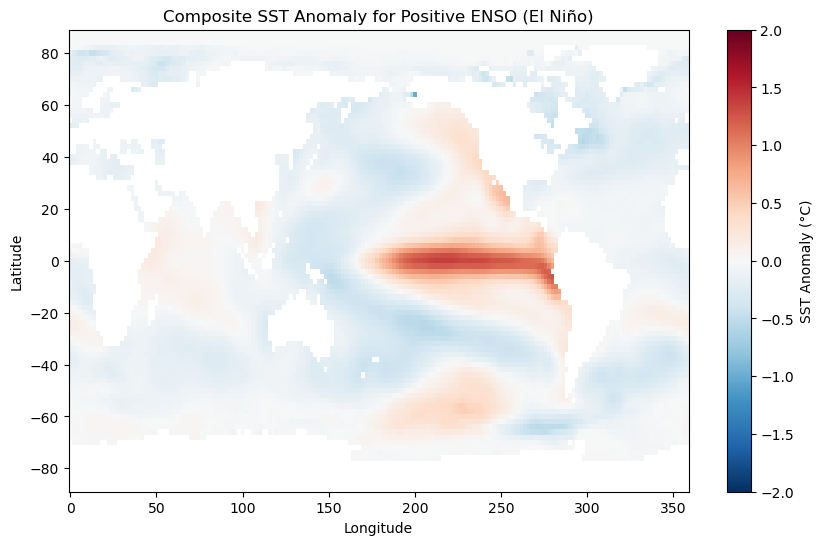

In [55]:
# Filter for positive ENSO regimes (El Niño: ONI >= +0.5°C)
positive_enso = sst_anomaly.sel(time=nino34_3m_mean['time'][nino34_3m_mean >= 0.5])

# Calculate the composite mean SST anomaly for positive ENSO regimes
positive_enso_composite = positive_enso.mean(dim='time')

# Plot the composite SST anomaly using pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    positive_enso_composite['lon'],
    positive_enso_composite['lat'],
    positive_enso_composite,
    cmap='RdBu_r',  # Diverging colormap
    shading='auto',  # Smooth color transitions
    vmin=-2, vmax=2  # Set colorbar limits for consistency
)
plt.colorbar(label="SST Anomaly (°C)")
plt.title("Composite SST Anomaly for Positive ENSO (El Niño)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(False)
plt.show()

And negative ONI.

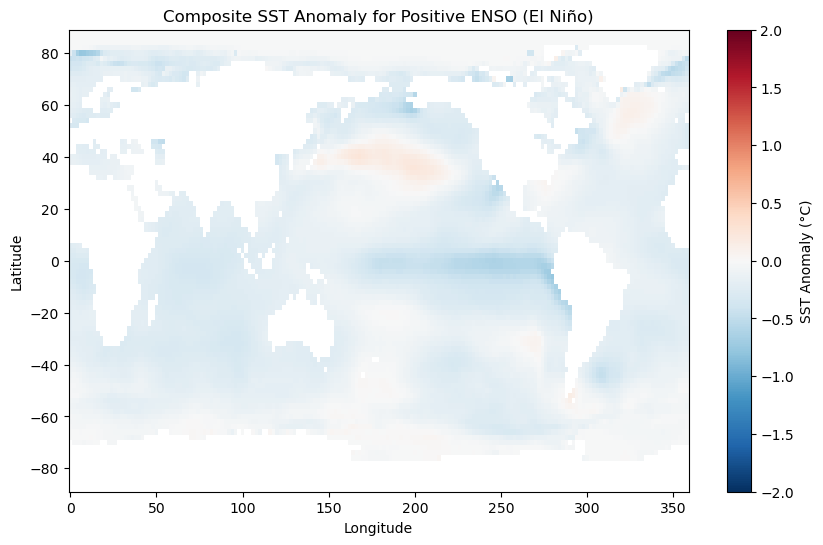

In [60]:
# Filter for negative ENSO regimes (El Niño: ONI >= -0.5°C)
positive_enso = sst_anomaly.sel(time=nino34_3m_mean['time'][nino34_3m_mean <= 0.5])

# Calculate the composite mean SST anomaly for positive ENSO regimes
positive_enso_composite = positive_enso.mean(dim='time')

# Plot the composite SST anomaly using pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    positive_enso_composite['lon'],
    positive_enso_composite['lat'],
    positive_enso_composite,
    cmap='RdBu_r',  # Diverging colormap
    shading='auto',  # Smooth color transitions
    vmin=-2, vmax=2  # Set colorbar limits for consistency
)
plt.colorbar(label="SST Anomaly (°C)")
plt.title("Composite SST Anomaly for Negative ENSO (El Niño)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(False)
plt.show()

### 4. Calculate the composite of preciptiation for positive and negative ENSO phases.

First load the precip dataset. Code to fix the broken time coordinate is included.

In [61]:
import pandas as pd
import xarray as xr
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NASA/.GPCP/.V2p1/.multi-satellite/.prcp/dods'
dsp = xr.open_dataset(url, decode_times=False)
true_time = (pd.date_range(start='1960-01-01', periods=len(dsp['T']), freq='MS'))
dsp['T'] = true_time
dsp = dsp.rename({'T': 'time'})
dsp.load()

<xarray.Dataset> Size: 15MB
Dimensions:  (time: 359, Y: 72, X: 144)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1960-01-01 1960-02-01 ... 1989-11-01
  * Y        (Y) float32 288B 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * X        (X) float32 576B 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Data variables:
    prcp     (time, Y, X) float32 15MB nan nan nan nan ... 0.1591 0.16 0.1623
Attributes:
    Conventions:  IRIDL

Now plot the *difference* between the time-mean of `prcp` during positive and negative ENSO phases.

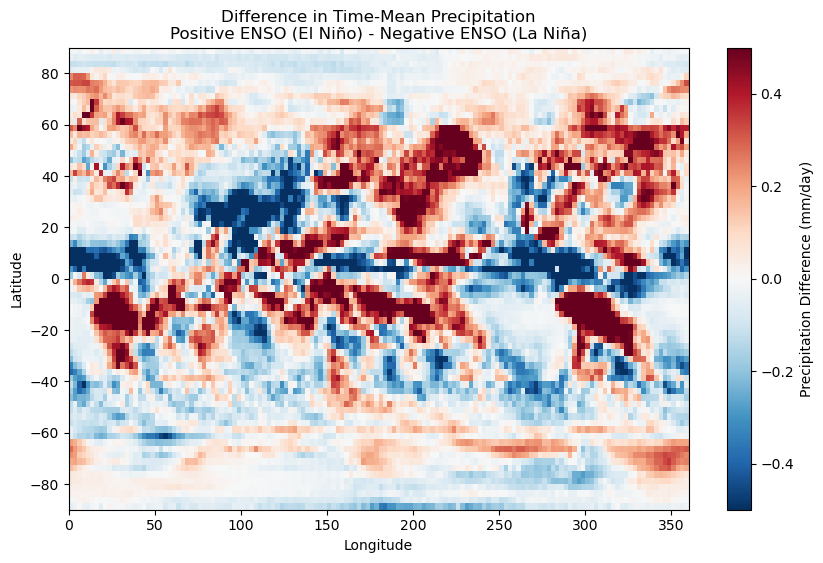

In [62]:
# Align ONI with precipitation dataset's time coordinate
oni_aligned = nino34_3m_mean.sel(time=dsp['time'])

# Filter for positive and negative ENSO phases
positive_enso_prcp = dsp['prcp'].sel(time=oni_aligned['time'][oni_aligned >= 0.5])
negative_enso_prcp = dsp['prcp'].sel(time=oni_aligned['time'][oni_aligned <= -0.5])

# Calculate the time-mean precipitation for each phase
positive_enso_mean = positive_enso_prcp.mean(dim='time')
negative_enso_mean = negative_enso_prcp.mean(dim='time')

# Calculate the difference between positive and negative ENSO means
enso_prcp_difference = positive_enso_mean - negative_enso_mean

# Plot the difference using pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    dsp['X'],  # Longitude
    dsp['Y'],  # Latitude
    enso_prcp_difference,
    cmap='RdBu_r',  # Diverging colormap
    shading='auto',  # Smooth color transitions
    vmin=-0.5, vmax=0.5  # Adjust based on data range
)
plt.colorbar(label="Precipitation Difference (mm/day)")
plt.title("Difference in Time-Mean Precipitation\nPositive ENSO (El Niño) - Negative ENSO (La Niña)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(False)
plt.show()